# Fractional Cover

## This notebook is currently under development!

## Notebook Summary

This notebook provides a fractional cover product which can be used to represent land cover. 

We're utilising Landsat 8 on AWS data https://docs.opendata.aws/landsat-pds/readme.html, and have indexed into an instance of the ODC, for more information about ODC please visit our landing page Landing Page.

The basis for this notebook below and the following explanation are from Digital Earth Australia http://geoscienceaustralia.github.io/digitalearthau/notebooks/02_DEA_datasets/Introduction_to_Fractional_Cover.html.

### What is Fractional Cover

Fractional Cover represents the proportion of the land surface that is bare (BS), covered by photosynthetic vegetation (PV), or non-photosynethic vegetation (NPV).

The Fractional Cover product was generated using the spectral unmixing algorithm developed by the Joint Remote Sensing Research Program (JRSRP) which used the spectral signature for each pixel to break it up into three fractions, based on field work that determined the spectral characteristics of these fractions. The fractions were retrieved by inverting multiple linear regression estimates and using synthetic endmembers in a constrained non-negative least squares unmixing model.

The green (PV) fraction includes leaves and grass, the non-photosynthetic fraction (NPV) includes branches, dry grass and dead leaf litter, and the bare soil (BS) fraction includes bare soil or rock.

### Fractional Cover Bands

Bare Soil (bare ground, rock, disturbed) (BS): - Bare Ground (bare soil, rock) percentage; Digital Number 10000 = 100%

Photosythetic Vegetation. (green grass, trees, etc.) (PV): - Photosynthetic Vegetation: Green Vegetation percentage;Digital Number 10000 = 100%

Non-Photosythetic vegetation (litter, dead leaf and branches) (NPV): - Non-Photosynthetic Vegetation (litter, dead leaves andbranches) percentage; Digital Number 10000 = 100%

Unmixing Error (UE): - Unmixing Error. The residual error, defined as the Euclidean Norm of the Residual Vector. High values express less confidence in the fractional components.

The initial instance of this product provides fractional cover of a single L8 image with cloud and water removal. Additional iterations will incorporate a time range for which the median product will be used to reduce the influence of cloud on the product.

Additionally a change product will be produced to allow for areas where changes in land cover have been experienced to be identified. 


### Import required modules

In [1]:
%matplotlib inline

import datacube
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from datacube.storage import masking



## Initialise

In [2]:
dc = datacube.Datacube(app='ls8-fcscene')

## Set up datacube query.
This includes options for crs, a groupby for overlapping datasets, a time range, and a spatial extent. 

In [3]:
query = {}
#query['product'] = 'ls8_usgs_fc_scene'  # for this example we will load some data from Landsat 8
query['output_crs'] = 'EPSG:3460'  # let's output our data in the Fiji projection
query['group_by'] = 'solar_day'  # datasets can often overlap, we will combine all data that occurs on the same day
query['time'] = ('2017-01-22', '2019-01-24') # set a time range for data acquisition
# You can specify a specific Sentinel 2 MGRS location using region code:
# query['region_code']='089079'
# alternatively you can create a bounding box, to do this you need three parameters:
#query['x'] = (177.9998, 179.0434)
#query['y'] = (-19.0809, -18.0857)
query['x'] = (178.2819, 178.6019)
query['y'] = (-18.2316, -18.0516)
#query['crs'] = 'EPSG:3460'

## Load Data 

In [ ]:
#Load rgb from L8 and pixel quality band, and display the image.  
qamasks = dc.load(
    product = 'ls8_usgs_sr_scene',
    resolution = (-30, 30),
    measurements = ['red', 'green', 'blue', 'pixel_qa'],
    **query
)
qamasks[['red','green','blue']].to_array().plot.imshow(
    col='time',
    figsize=(10, 8),
    vmin=0,
    vmax=3000
);

In [ ]:
# Identify pixels with valid data:
unwanted_pixels = (
    (qamasks.pixel_qa == 322)  | # clear
    (qamasks.pixel_qa == 386)  |
    (qamasks.pixel_qa == 834)  |
    (qamasks.pixel_qa == 898)  |
    (qamasks.pixel_qa == 1346) |
    (qamasks.pixel_qa == 324) #water
)

In [ ]:
#load the bands of the fractional cover product. 
full_resolution = dc.load(
    resolution = (-30, 30), # this is the 'native' or 'full' resolution of Landsat data
    measurements=['PV','BS','NPV','UE'],
    product = 'ls8_usgs_fc_scene',
    **query #use the query we defined above
)

## Plot Fractional Cover and Unmixing Error bands

The Unmixing Error is high over water. 

In [ ]:
#plot the fractional cover bands. 
scene = 0
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
full_resolution.PV.isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
full_resolution.BS.isel(time=scene).plot(cmap='Oranges')
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
full_resolution.NPV.isel(time=scene).plot(cmap='copper')
ax3.set_title('NPV')

ax4=plt.subplot(gs[1,1])
full_resolution.UE.isel(time=scene).plot(cmap='magma')
ax4.set_title('UE')

plt.tight_layout()
plt.show()

### To remove the error, the UE band can be filtered - although WOfS provides a more robust mask. 

In [ ]:
#this image shows that you can filter using unmixing error if you wish
plt.figure(figsize=(12,8))
full_resolution.UE.where(full_resolution.UE<=40.0).isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('UE filtered')

## Filter Fractional cover scenes using WOfS feature layers (WOFLs)

WOfS provides a scene by scene mask to remove areas of water. Additional it provides cloud and cloud shadow masks. 

dry  {'bits': [7, 6, 5, 0], 'values': {'0': True}, 'description': 'Clear and dry'}
sea  {'bits': 2, 'values': {'0': False, '1': True}, 'description': 'Sea'}
wet  {'bits': [7, 6, 5, 0], 'values': {'128': True}, 'description': 'Clear and Wet'}
cloud  {'bits': 6, 'values': {'0': False, '1': True}, 'description': 'Cloudy'}
nodata  {'bits': 0, 'values': {'1': True}, 'description': 'No data'}
cloud_shadow  {'bits': 5, 'values': {'0': False, '1': True}, 'description': 'Cloud shadow'}
water_observed  {'bits': 7, 'values': {'0': False, '1': True}, 'description': 'Classified as water by the decision tree'}


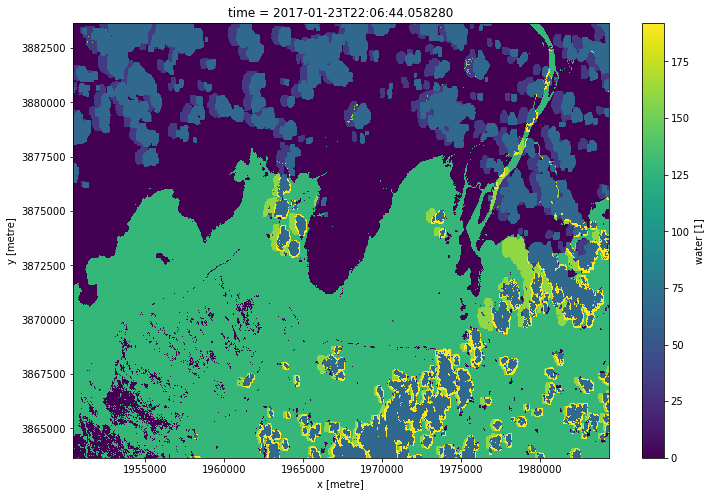

In [10]:
#Load the WOfS feature layers (wofls), using the same query options as the Fractional cover product. 
wofls = dc.load(
    product = 'ls8_usgs_wofs_scene',
    resolution = (-30, 30),
    **query
)

#print each of the WOfS bit flags and plot
for key in wofls.water.flags_definition.keys():
    print('{}  {}'.format(key, wofls.water.flags_definition[key]))
plt.figure(figsize=(12,8))
wofls.water.isel(time=0).plot()


## Create mask layers based on WOfS.

Masks for to remove undesired features from the fractional cover product - clouds, cloud-shadow and water. 

In [11]:
clearwofl = masking.make_mask(wofls, dry=True)
wetwofl = masking.make_mask(wofls, wet=True)
cloudwofl = masking.make_mask(wofls, cloud=True)
cloudshwofl = masking.make_mask(wofls, cloud_shadow=True)


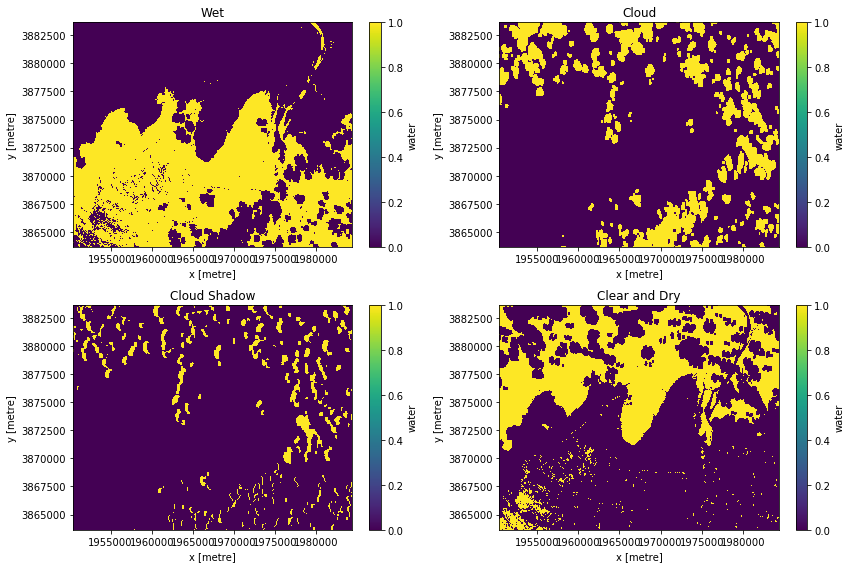

In [12]:
#Plot showing each of the created masks. 
scene = 0
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
wetwofl.water.isel(time=0).plot()
ax1.set_title('Wet')

ax2=plt.subplot(gs[1,0])
cloudshwofl.water.isel(time=0).plot()  
ax2.set_title('Cloud Shadow')

ax3=plt.subplot(gs[0,1])
cloudwofl.water.isel(time=0).plot()  
ax3.set_title('Cloud')

ax4=plt.subplot(gs[1,1])
clearwofl.water.isel(time=0).plot()  
ax4.set_title('Clear and Dry')

plt.tight_layout()
plt.show()

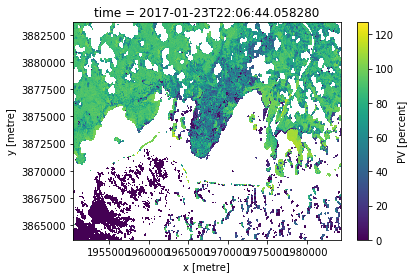

In [14]:
#match WOFL times to our fractional cover times
unwofld = full_resolution.where(full_resolution.time == wetwofl.time)
#unwofld = full_resolution.where(full_resolution.output_crs == wetwofl.output_crs)
#mask out water, clouds and cloudshadow from fractional cover
unwofld = unwofld.where(wetwofl.water==False).where(cloudwofl.water==False).where(cloudwofl.water==False)
#plot masked PV> 
unwofld.PV.isel(time=0).plot()

## Create a plot showing FC components.

#Current mask issues in south west corner - with the water mask. 

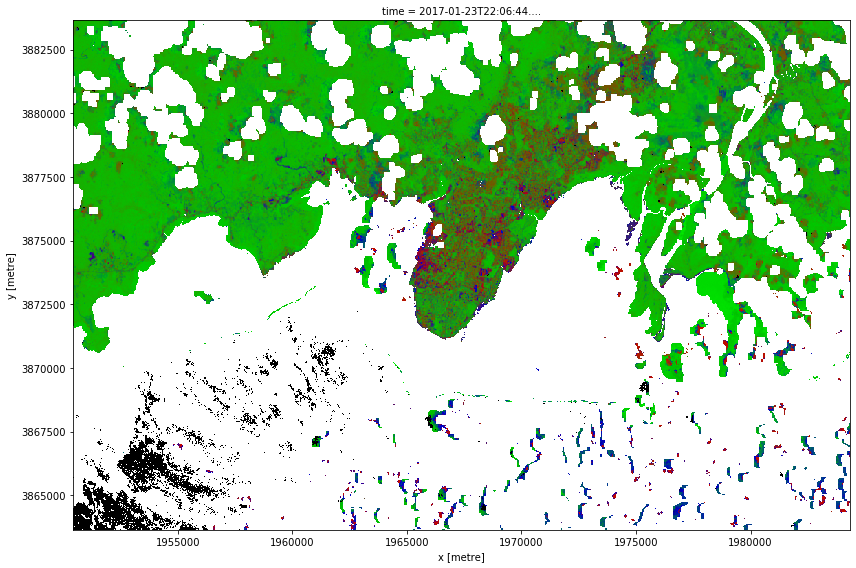

In [15]:
# Plot fractional cover as cloud free RGB image
unwofld[['BS','PV','NPV']].to_array().plot.imshow(
    col='time',
    figsize=(12, 8),
    vmin=0,
    vmax=3000
);